# ARIMA forecasting
Models number of samples per year based on main disease categories using an ARIMA regression

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import copy

# load tree
path = '../../data/final'
tree_file = 'mesh.pkl'
trdf = pd.read_pickle(os.path.join(path, tree_file))

# load counts
countdf = pd.read_pickle(os.path.join(path,'countsbyyear_for_plotting.pkl'))
sampledf = pd.read_pickle(os.path.join(path,'samplesbyyear_for_plotting.pkl'))
sampledf = sampledf.rename(index=str, columns = {'nsamples':'c'})

# load top topics based on n series
countsdf = pd.read_pickle(os.path.join(path,'meshids_rankedby_NSeries.pkl'))
countsdf = pd.merge(countsdf,trdf, on='mesh_id', how='left')
countsdf = countsdf.loc[np.isin(countsdf.category, ['C'])].reset_index(drop=True)
orderhue = countsdf.loc[countsdf.mesh_treenumbers.str.len() ==3,['mesh_heading', 'n']].drop_duplicates().reset_index(drop=True)[:12].mesh_heading.tolist()

vizpath = '../../reports/figures/desc'

if os.path.isdir(vizpath)==False:
    os.mkdir(vizpath)

# Use mesh headings to select
input_in_mesh_headings_or_mesh_id = 0 # mesh_heading: 0, mesh_id: 1
diseases = orderhue
if input_in_mesh_headings_or_mesh_id == 0:
    x = sampledf.loc[np.isin(sampledf.mesh_heading, diseases),:]
else:
    x = sampledf.loc[np.isin(sampledf.mesh_id, diseases),:]

# Run ARIMA forcasting
p is the number of autoregressive terms, 
d is the number of nonseasonal differences needed for stationarity 
q is the number of lagged forecast errors in the prediction equation

In [2]:
# call ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction

# gen predictions and error on the test set
def gen_predictions_test_set(x, plott):
    #Size 
    ActualData = np.array(x.c)
    NumberOfElements = len(ActualData)
    #Use 80% of data as training, rest 30% to Test model
    TrainingSize = int(NumberOfElements * 0.8)
    TrainingData = ActualData[0:TrainingSize]
    TestData = ActualData[TrainingSize:NumberOfElements]
    #new arrays to store actual and predictions
    Actual = [x for x in TrainingData]
    Predictions = list()
    #in a for loop, predict values using ARIMA model
    for timepoint in range(len(TestData)):
        ActualValue =  TestData[timepoint]
        #forcast value
        Prediction = StartARIMAForecasting(Actual, 1,1,0)
        if plott==1:
            print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
        #add it in the list
        Predictions.append(Prediction[0])
        Actual.append(ActualValue)
    Error = np.sqrt(mean_squared_error(TestData, Predictions))
    if plott == 1:
        print('Test Root Mean Squared Error: %.3f' % Error)
        # plot
        plt.plot(TestData)
        plt.plot(Predictions, color='red')
        plt.show()
    return pd.Series({'rmse':Error, 'y_test':TestData, 'prediction_test':Predictions})

plot_outputs = 0
test_error_df = x.groupby('mesh_heading').apply(lambda x: gen_predictions_test_set(x,plot_outputs))
print('The Root mean squared error of the model averaged across main disease categories is:')
print(test_error_df.rmse.mean())

The Root mean squared error of the model averaged across main disease categories is:
5117.575098966846


# Generate future predictions

['Animal Diseases']


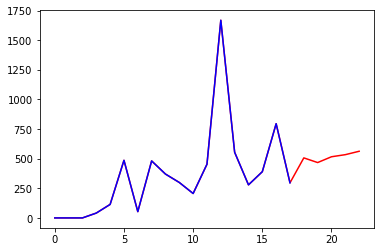

['Animal Diseases']


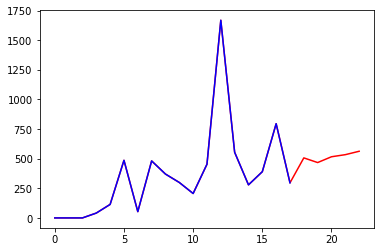

['Cardiovascular Diseases']


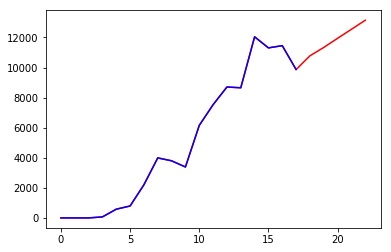

['Congenital, Hereditary, and Neonatal Diseases and Abnormalities']


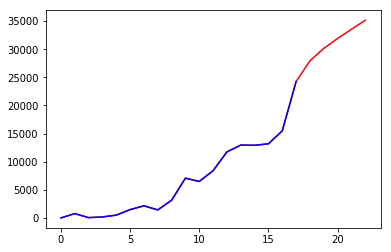

['Endocrine System Diseases']


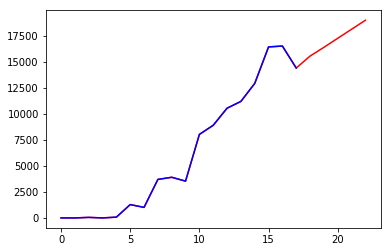

['Eye Diseases']


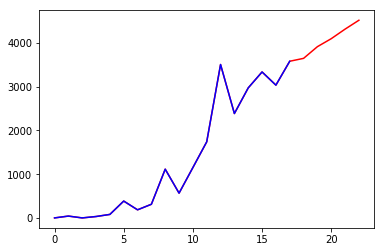

['Immune System Diseases']


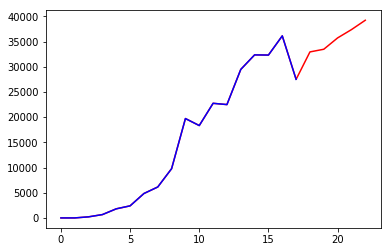

['Musculoskeletal Diseases']


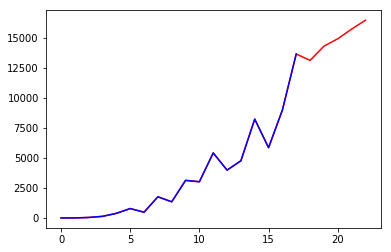

['Neoplasms']


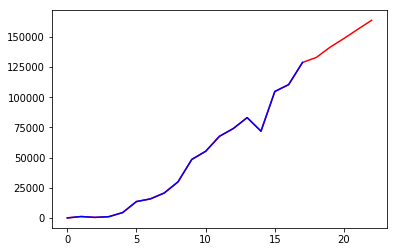

['Nervous System Diseases']


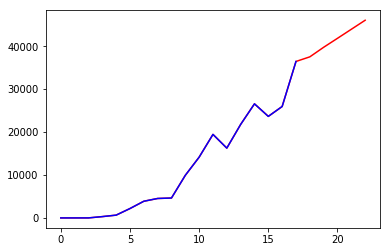

['Respiratory Tract Diseases']


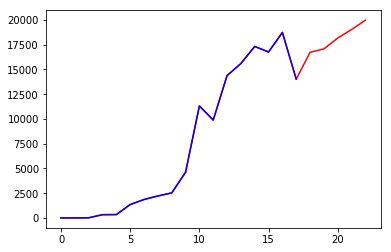

['Skin and Connective Tissue Diseases']


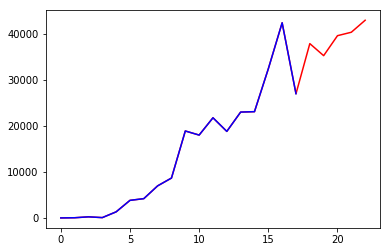

['Virus Diseases']


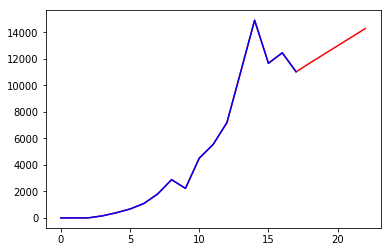

/Users/clairechambers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
def gen_predictions_future(x,npred):
    #Size 
    ActualData = list(x.c)
    #new arrays to store actual and predictions
    Actual = list(x.c)
    Predictions = list()
    #in a for loop, predict values using ARIMA model
    for timepoint in range(npred):
        #forcast value
        Prediction = StartARIMAForecasting(Actual, 1,1,0)         
        Predictions.append(Prediction[0])
        Actual.append(Prediction[0])
    print(x.mesh_heading.unique())
    plt.plot(Actual, color=[1,0,0], alpha=1)
    plt.plot(ActualData, color=[0,0,1],alpha=1)
    plt.show()
    return pd.Series({'prediction':Predictions})

npredictions = 5
ypredictions = x.groupby('mesh_heading').apply(lambda x :gen_predictions_future(x,npredictions)).reset_index()

# merge with countdf
maxyear = countdf.year.max()
predict_years = np.arange(maxyear+1, maxyear+npredictions+1).tolist()
p = ypredictions['prediction'].apply(pd.Series)
p.columns = predict_years
# merge back to ypredictions
p['mesh_heading'] = ypredictions['mesh_heading']
p = pd.melt(p, id_vars = 'mesh_heading')
p = p.rename(index = str,columns ={'variable':'year', 'value': 'c'} )
mesh_df = countdf[['mesh_id', 'mesh_heading']].drop_duplicates()
p = pd.merge(p,mesh_df, how='left', on='mesh_heading')
p['prediction'] = 1
x['prediction'] = 0
count_prediction_df = pd.concat([x,p],axis=0,sort=True).reset_index(drop=True)


# Plot future predictions

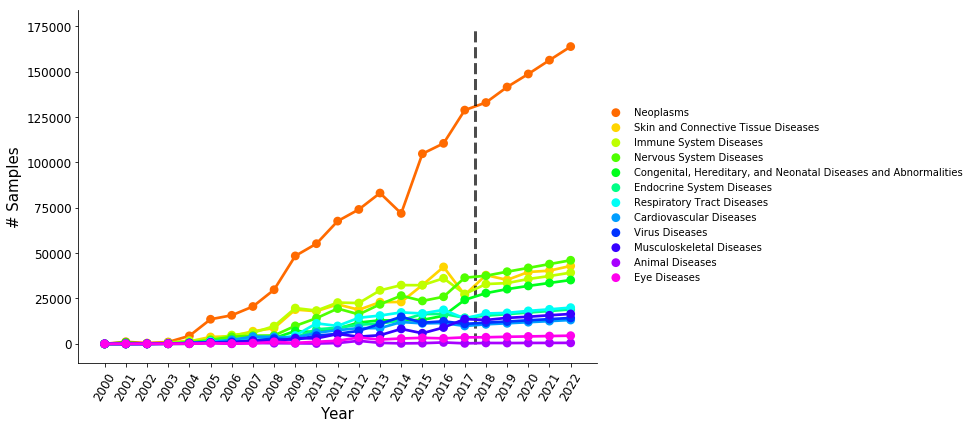

In [4]:
file = 'disease_predictions.pdf'
filename = os.path.join(vizpath, file)

my_cmap_main = sns.color_palette("hsv",13).as_hex()

label_font = 15
ticks_font = 12

fig,axs =plt.subplots(1,1, figsize=(12,7))
ax = axs
sns.pointplot(data=count_prediction_df, x='year', y = 'c', hue='mesh_heading',ax=ax, palette=my_cmap_main, hue_order=orderhue) # hue_order=ordering
ax.plot([17.5,17.5], [0,175000], ls='--', color=[0,0,0], lw=3, alpha=.7)

ax.set_xticks(range(len(count_prediction_df.year.unique())))
ax.set_xticklabels(count_prediction_df.year.unique(), rotation=60,fontsize=ticks_font)
ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=ticks_font)
ax.set_xlabel('Year',fontsize = label_font)
ax.set_ylabel('# Samples',fontsize = label_font)
ax.legend(bbox_to_anchor = (1,.75),frameon=False)

sns.despine()

fig.subplots_adjust(left=.1, bottom=.2, right=.7, top=.9, wspace=.2, hspace=.1)

plt.savefig(filename, papertype = 'a4', orientation = 'portrait', format = 'pdf') 